<a href="https://colab.research.google.com/github/sairampolina/Lucas-Kanade-Feature-Tracking/blob/master/Lucas_kanade_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necesssary libraries

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import interpolate

# Download hotel sequence images (total 51images)

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fT0H-FbbDZnjMfCJHZcscpcwAXHhGgNw
!unzip "/content/part1_images.zip" -d "/content/"

# Functions

In [16]:
def readImages(folder, num_images):
  arr_images = []
  for i in range(num_images):
    arr_images.append(cv2.imread(f'{folder}hotel.seq{i}.png'))
  return np.array(arr_images, dtype=np.float32)

def getKeypoints(img, tau):
  '''
  Detecting keypoints using Harris corner criterion
  This keypoints are obtained from image 1.We will track these keypoints 
  across the image sequence to obtain keypoint tracking.
  img: input image
  tau: threshold 
  
  output: array of [x,y] keypoints, size = (N,2)
          where N is number of keypoints.
  '''


  # computing grayscale of an image
  grayImage=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  # smoothing the image (Usually done before calculating gradient)
  smoothedImage=cv2.GaussianBlur(grayImage,(7,7),0.8)

 
  # computing x-gradient and y-gradient of the image
  yGradient,xGradient=np.gradient(smoothedImage)

  # computing components of H-matrix
  Ixx=xGradient*xGradient
  Iyy=yGradient*yGradient
  Ixy=xGradient*yGradient


  # calculating weighted gradients
 
  s_Ixx=cv2.GaussianBlur(Ixx,(5,5),2)
  s_Iyy=cv2.GaussianBlur(Iyy,(5,5),2)
  s_Ixy=cv2.GaussianBlur(Ixy,(5,5),2)

  # constructing H for each pixel
  harrisFactorsArray=np.zeros_like(grayImage)
  height,width=harrisFactorsArray.shape

  for h_i in range(height):
    for w_i in range(width):
      matrixH=np.array([[s_Ixx[h_i,w_i],s_Ixy[h_i,w_i]],[s_Ixy[h_i,w_i],s_Iyy[h_i,w_i]]])

      harrisFactorsArray[h_i,w_i]=np.linalg.det(matrixH)/np.trace(matrixH)
    
  # normalizing values in between [0,1]
  nHarrisFactorsArray=cv2.normalize(harrisFactorsArray,dst=harrisFactorsArray,alpha=0,beta=1,norm_type=cv2.NORM_MINMAX)
  
  plt.figure(figsize=(11,11))
  plt.subplot(1,2,1)
  plt.title("Harris Factors image")
  plt.imshow(nHarrisFactorsArray,cmap="gray")
  
  
  # threshholding image
  thresholdedHarrisFactorsArray=np.where(nHarrisFactorsArray>tau,nHarrisFactorsArray,0)

  plt.subplot(1,2,2)
  plt.imshow(thresholdedHarrisFactorsArray,cmap="gray")
  plt.title("Harris Factors image after thresholding")
  plt.show()

  # performing non-maxima supression

  height1,width1=thresholdedHarrisFactorsArray.shape
  kernelsize=5

  nonmaxImage=np.zeros_like(thresholdedHarrisFactorsArray)


  for h_i in range((height1-kernelsize)+1):
    for w_i in range ((width1-kernelsize)+1):

      originalPatch=thresholdedHarrisFactorsArray[h_i:h_i+kernelsize,w_i:w_i+kernelsize]
      nonmaxPatch=nonmaxImage[h_i:h_i+kernelsize,w_i:w_i+kernelsize]

      maxValue=originalPatch.max()
      if(originalPatch[2,2]==maxValue):
        nonmaxPatch[2,2]=maxValue
  
  # Extracting non-zero indices
  ypoints,xpoints=np.nonzero(nonmaxImage)

  indicesArray=np.argwhere(nonmaxImage)

  print(f"Number of keypoints detected is:{indicesArray.shape}")
  
  # plotting extracted corners
  plt.figure(figsize=(7,7))
  plt.imshow(np.uint8(img[:,:,::-1]))
  plt.plot(xpoints,ypoints,'go',markersize=3)
  plt.title("Detected key-points in image-1")
  plt.savefig("1_s1.png")
  plt.show()
  
  # returning keypoints indices in image coordinate system
  return indicesArray[:,::-1]

def getNextPoints(x, y, im1, im2, ws):
  '''
  Iterative Lucas-Kanade feature tracking
  x,  y : initialized keypoint position in im1
  ws: patch window size

  output: tracked keypoint positions in im2
  '''
  # convert images to grayscale
  im1=cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
  im2=cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)
  
  border=ws//2
  
  # computing x and y gradients of image1
  smoothedImage=cv2.GaussianBlur(im1,(7,7),0.8)
  Iy,Ix=np.gradient(smoothedImage)

  ## interpolation functions for Images, x-gradient, and y-gradient
  rangeX=np.arange(0,512)
  rangeY=np.arange(0,480)
  
  im1F=interpolate.interp2d(rangeX,rangeY,im1,kind="linear",fill_value=0)
  im2F=interpolate.interp2d(rangeX,rangeY,im2,kind="linear",fill_value=0)
  IxF=interpolate.interp2d(rangeX,rangeY,Ix,kind="linear",fill_value=0)
  IyF=interpolate.interp2d(rangeX,rangeY,Iy,kind="linear",fill_value=0)

  x_points=[]
  y_points=[]
  
  # for each point find next point
  for i in range(len(x)):

    x1=x[i]
    y1=y[i]

    # initializing x2, y2
    x2=x1
    y2=y1

    # creating indices around keypoint
    xindicesPatch1=np.linspace(x1-7,x1+7,15)
    yindicesPatch1=np.linspace(y1-7,y1+7,15)
    
    # acces x-gradient patch and y gradient patch from interpolated functions
    IxPatch1=IxF(xindicesPatch1,yindicesPatch1)
    IyPatch1=IyF(xindicesPatch1,yindicesPatch1)

    # constructing 2nd moment matrix
    Ixx=IxPatch1*IxPatch1
    Iyy=IyPatch1*IyPatch1
    Ixy=IxPatch1*IyPatch1

    A=np.array([[np.sum(Ixx),np.sum(Ixy)],[np.sum(Ixy),np.sum(Iyy)]])
    
    # constructing matrix b
    patch1=im1F(xindicesPatch1,yindicesPatch1)
    
    u=5
    v=5

    # iterate until you minimize u and v
    while((u < 1.1 and v < 1.1) != True):

      # boundary condition
      if((x2 < 0 or x2 > 511) or (y2 < 0 or y2 > 479)):
        break

      # patch2
      xindicesPatch2=np.linspace(x2-7,x2+7,15)
      yindicesPatch2=np.linspace(y2-7,y2+7,15)
      patch2=im2F(xindicesPatch2,yindicesPatch2)
      
      # calculating It (temporal difference between patches in 2 different images)
      It=patch2-patch1

      b1=np.vdot(IxPatch1,It)
      b2=np.vdot(IyPatch1,It)
      
      b=np.array([b1,b2])
      
      try:
        d=np.linalg.solve(A,-b)
      except:
        print("error")

      u = d[0]
      v = d[1]
     

      # updating x2,y2
      x2=x2+u
      y2=y2+v

    if((x2<0 or x2>511) or (y2<0 or y2>479)):
      x_points.append(0)
      y_points.append(0)
    else:
      x_points.append(x2)
      y_points.append(y2)  

  return (np.array(x_points),np.array(y_points))

def trackPoints(pt_x, pt_y, im, ws):
 
  '''
  Tracking initial points (pt_x, pt_y) across the image sequence
  Outputs:
    track_x: (Number of keypoints,no of images), x indices of keypoint across 
              the image sequences.  
    track_y: (Number of keypoints,no of images), y indices of keypoint across 
              the image sequences.
  '''
  N = int(np.prod(pt_x.shape))
  nim = len(im)
  track_x = np.zeros((N, nim))
  track_y = np.zeros((N, nim))
  track_x[:,0] = pt_x
  track_y[:,0] = pt_y

 
  for t in range(nim-1):
    # print(f"iteration:{t}")
    track_x[:, t+1], track_y[:, t+1]= getNextPoints(track_x[:, t], track_y[:, t], im[t,:,:], im[t+1,:,:], ws)
  return track_x, track_y

# Pipeline:

##  1. Read all images and display 1st and last image in sequence

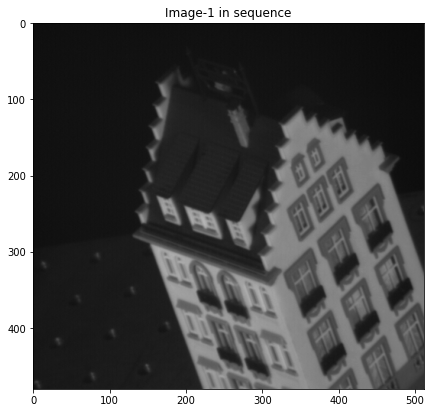

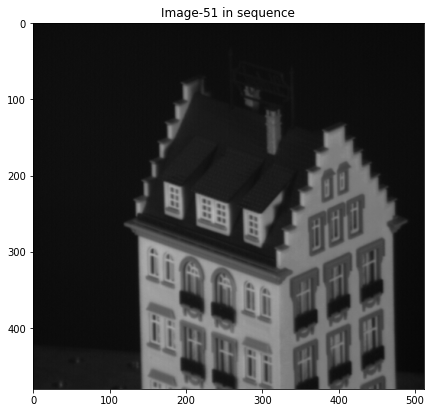

In [12]:
# read images
# read all 51 sequences of images
folder = '/content/part1_images/'
im = readImages(folder, 51)

# Displaying original image
plt.figure(figsize=(7,7))
plt.imshow(np.uint8(im[0][:,:,::-1]))
plt.title("Image-1 in sequence")
plt.show()

# Displaying original image
plt.figure(figsize=(7,7))
plt.imshow(np.uint8(im[50][:,:,::-1]))
plt.title("Image-51 in sequence")
plt.show()


## 2. Detect keypoints in image 1 , which are tracked using lucas-kanade tracking.

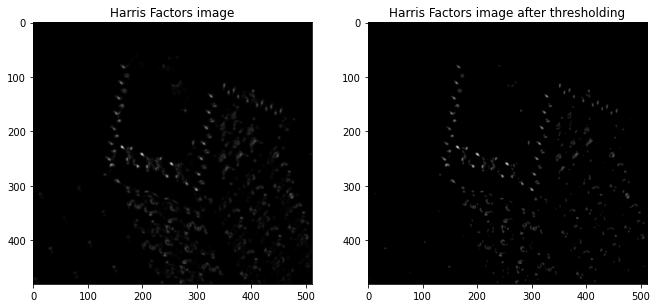

Number of keypoints detected is:(419, 2)


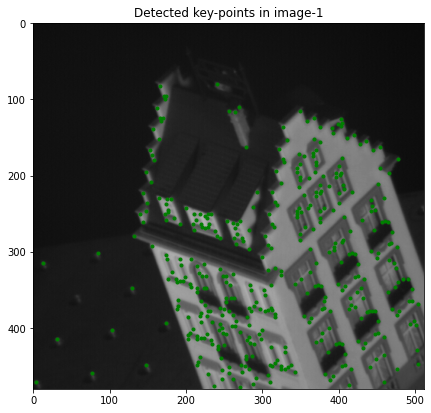

In [15]:
# first find the keypoints inimage 1,which will be used for tracking.
tau = 0.09
key_pts = getKeypoints(im[0], tau)

## 3. Track keypoints detected im image1 across the sequence.

In [17]:
ws = 7
tracked_pts = trackPoints(pt_x=key_pts[:,0], pt_y=key_pts[:,1], im=im, ws=ws)

## 4.Plotting the points obtained from Lucas-Kanade tracking algorithm

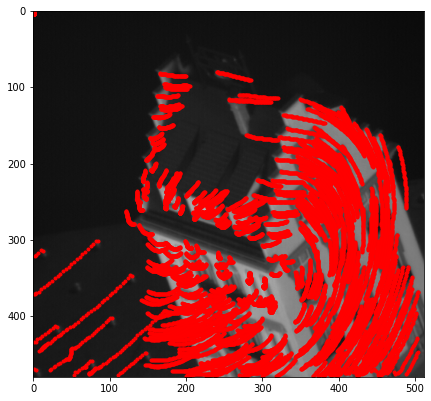

In [18]:
# plotting extracted corners in sequence
plt.figure(figsize=(7,7))
plt.imshow(np.uint8(im[0][:,:,::-1]))
for i in range(0,51,1):
  plt.plot(tracked_pts[0][:,i],tracked_pts[1][:,i],'ro',markersize=3)
plt.show()